# DBSCAN

**D**ensity **B**ased **S**patial **C**lustering of **A**pplications with **N**oise or [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) identifies the clusters based on nearest neighbors of core points. A core point is defined a pont that has $\ge n$ pointes within a defined radius $\epsilon$.

DBSCAN is a density-based clustering algorithm that groups together closely packed points (core points) and marks outliers (noise) that lie alone in low-density regions. It requires two parameters:
  - $\epsilon$. (epsilon): the maximum distance between two samples for them to be considered as neighbors.
  - __minPts__ $n$: the minimum number of neighbors within $\epsilon$. to qualify a point as a core point.


## 🧠 Core Ideas Recap
 - Core Point: A point with at least __minPts__ neighbors within $\epsilon$.
 - Border Point: A point within $\epsilon$ of a core point but with fewer than __minPts__ neighbors.
 - Noise Point: A point that is neither a core point nor a border point.
 - Clusters: Formed by recursively expanding reachable core points and adding their neighbors.

In [1]:
import numpy as np

class SimpleDBSCAN:
    def __init__(self, eps, min_samples):
        self.epsilon = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        n = len(X)
        self.labels_ = np.full(n, -1)
        visited = np.zeros(n, dtype=bool)
        cluster_id = 0

        for i in range(n):
            if visited[i]:
                continue

            visited[i] = True
            neighbors = self.get_neighbors(X, i)

            if len(neighbors) < self.min_samples:
                self.labels_[i] = -1
                continue

            self.expand_cluster(X, i, neighbors, cluster_id, visited)
            cluster_id += 1

    def get_neighbors(self, X, i):
        # Return the indices of the points within epsilon of the point i
        # Return X[i] as well
        return np.where(np.linalg.norm(X - X[i], axis=1) <= self.epsilon)[0].tolist()

    def expand_cluster(self, X, i, neighbors, cluster_id, visited):
        self.labels_[i] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor = neighbors[i]
            if visited[neighbor]:
                i += 1
                continue

            visited[neighbor] = True
            # mimics BFS using neighbors[] as queue
            neighbor_neighbors = self.get_neighbors(X, neighbor)
            if len(neighbor_neighbors) >= self.min_samples:
                    # Extend neighbors for core points only
                    neighbors.extend(neighbor_neighbors)
            # Border points fall here
            if self.labels_[neighbor] == -1:
                self.labels_[neighbor] = cluster_id

            i += 1

In [2]:
# Create test data of 2D points
# 1. Points in a circle with radius 5+random(eps) of each other, centered at (5, 5)
# 2. POints in a square with side length 2+random(eps), centered at (5, 5)
# 3 Points as circle with radius 1+random(eps) centered at (5,5)
# 4. Noisy points
np.random.seed(1024)
def generate_points_circle(n, radius, center=(0, 0)):
    # Generate n points is a cirlcle with radius+random(eps) of each other, centered at center
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    return np.column_stack((x, y))

In [3]:
def generate_points_square(n, length, center=(0, 0)):
    cx, cy = center
    side_pts = n // 4
    r = length / 2
    rem = n % 4

    # Define side edges
    top = np.column_stack((
        np.linspace(cx - r, cx + r, side_pts +
                    (1 if rem > 0 else 0), endpoint=False),
        np.full(side_pts + (1 if rem > 0 else 0), cy + r)
    ))
    right = np.column_stack((
        np.full(side_pts + (1 if rem > 1 else 0), cx + r),
        np.linspace(cy + r, cy - r, side_pts +
                    (1 if rem > 1 else 0), endpoint=False)
    ))
    bottom = np.column_stack((
        np.linspace(cx + r, cx - r, side_pts +
                    (1 if rem > 2 else 0), endpoint=False),
        np.full(side_pts + (1 if rem > 2 else 0), cy - r)
    ))
    left = np.column_stack((
        np.full(side_pts, cx - r),
        np.linspace(cy - r, cy + r, side_pts, endpoint=False)
    ))

    # Concatenate all edges
    points = np.vstack((top, right, bottom, left))
    return points  # Ensure exact number if more than needed

In [4]:
c1 = generate_points_circle(400, 6, (5, 5))
c2 = generate_points_circle(100, 2, (5, 5))
c3 = generate_points_square(100, 1, (5, 5))
c4 = generate_points_square(300, 7, (5, 5))
# combine all points
all_points = np.vstack((c1, c2, c3, c4))
jitter = np.random.uniform(-0.25, 0.25, size=all_points.shape)
all_points += jitter

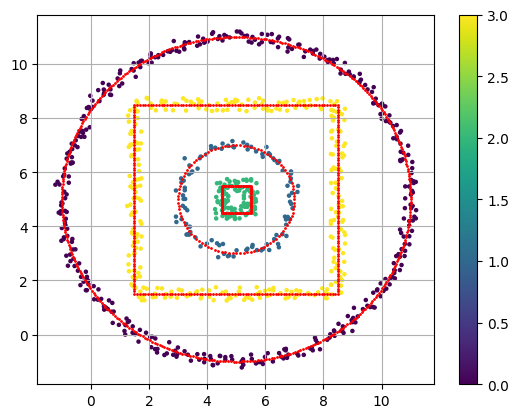

In [5]:
import matplotlib.pyplot as plt
db = SimpleDBSCAN(eps=0.6, min_samples=3)
db.fit(all_points)
plt.scatter(all_points[:, 0], all_points[:, 1], c=db.labels_, cmap='viridis', s=5)
plt.plot(c1[:, 0], c1[:, 1], 'ro', label='C1', markersize=1)
plt.plot(c2[:, 0], c2[:, 1], 'ro', label='C2', markersize=1)
plt.plot(c3[:, 0], c3[:, 1], 'ro', label='Square', markersize=1)
plt.plot(c4[:, 0], c4[:, 1], 'ro', label='Noisy', markersize=1)
plt.grid(True)
plt.colorbar()
plt.show()

In [6]:
values, counts = np.unique_counts(db.labels_)
for value, count in zip(values, counts):
    print(f"Cluster {value}: {count} points")


Cluster 0: 400 points
Cluster 1: 100 points
Cluster 2: 100 points
Cluster 3: 300 points


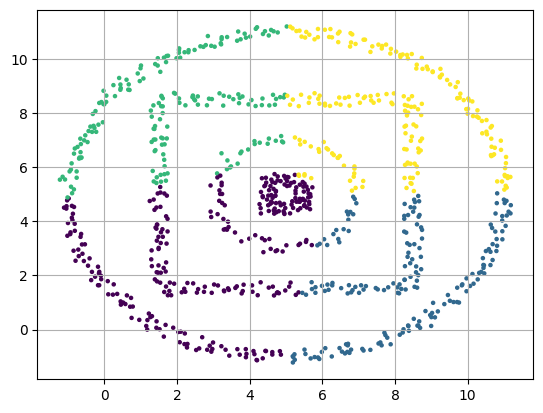

In [7]:
# For comparison with KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=1024)
kmeans.fit(all_points)
plt.scatter(all_points[:, 0], all_points[:, 1], c=kmeans.labels_, cmap='viridis', s=5)
plt.grid(True)
plt.show()

In [8]:
values, counts = np.unique_counts(kmeans.labels_)
for value, count in zip(values, counts):
    print(f"Cluster {value}: {count} points")

Cluster 0: 314 points
Cluster 1: 191 points
Cluster 2: 191 points
Cluster 3: 204 points
